In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split



2025-10-21 04:17:03.024994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761020223.192247      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761020223.242618      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import kagglehub

path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [3]:
data_dir = "/kaggle/input/plantvillage-dataset/color"

classes = sorted(os.listdir(data_dir))

class_mapping = {}
for i in classes:
    cleaned_cls = i.replace('___', ' - ').replace('_', ' ').replace(',', '')
    class_mapping[i] = cleaned_cls

cleaned_classes = list(class_mapping.values())
print("Total classes:", len(cleaned_classes))
for i in cleaned_classes:
    print(i)


Total classes: 38
Apple - Apple scab
Apple - Black rot
Apple - Cedar apple rust
Apple - healthy
Blueberry - healthy
Cherry (including sour) - Powdery mildew
Cherry (including sour) - healthy
Corn (maize) - Cercospora leaf spot Gray leaf spot
Corn (maize) - Common rust 
Corn (maize) - Northern Leaf Blight
Corn (maize) - healthy
Grape - Black rot
Grape - Esca (Black Measles)
Grape - Leaf blight (Isariopsis Leaf Spot)
Grape - healthy
Orange - Haunglongbing (Citrus greening)
Peach - Bacterial spot
Peach - healthy
Pepper bell - Bacterial spot
Pepper bell - healthy
Potato - Early blight
Potato - Late blight
Potato - healthy
Raspberry - healthy
Soybean - healthy
Squash - Powdery mildew
Strawberry - Leaf scorch
Strawberry - healthy
Tomato - Bacterial spot
Tomato - Early blight
Tomato - Late blight
Tomato - Leaf Mold
Tomato - Septoria leaf spot
Tomato - Spider mites Two-spotted spider mite
Tomato - Target Spot
Tomato - Tomato Yellow Leaf Curl Virus
Tomato - Tomato mosaic virus
Tomato - healthy


In [4]:
file_paths = []
labels = []

for label, cls in enumerate(classes):
    cls_dir = os.path.join(data_dir, cls)
    for img_file in os.listdir(cls_dir):
        file_paths.append(os.path.join(cls_dir, img_file))
        labels.append(label)

file_paths = np.array(file_paths)
labels = np.array(labels)

print("Total images:", len(file_paths))
print("Example path:", file_paths[0])
print("Example label:", labels[0])

Total images: 54305
Example path: /kaggle/input/plantvillage-dataset/color/Apple___Apple_scab/5a178d63-372d-48c4-adb8-d616130ba3f0___FREC_Scab 3104.JPG
Example label: 0


In [5]:
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}
class_counts = pd.DataFrame(list(class_counts.items()), columns = ['Class', 'Image_counts'])

class_counts

,Class,Image_counts
0,Apple___Apple_scab,630
1,Apple___Black_rot,621
2,Apple___Cedar_apple_rust,275
3,Apple___healthy,1645
4,Blueberry___healthy,1502
5,Cherry_(including_sour)___Powdery_mildew,1052
6,Cherry_(including_sour)___healthy,854
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,513
8,Corn_(maize)___Common_rust_,1192
9,Corn_(maize)___Northern_Leaf_Blight,985


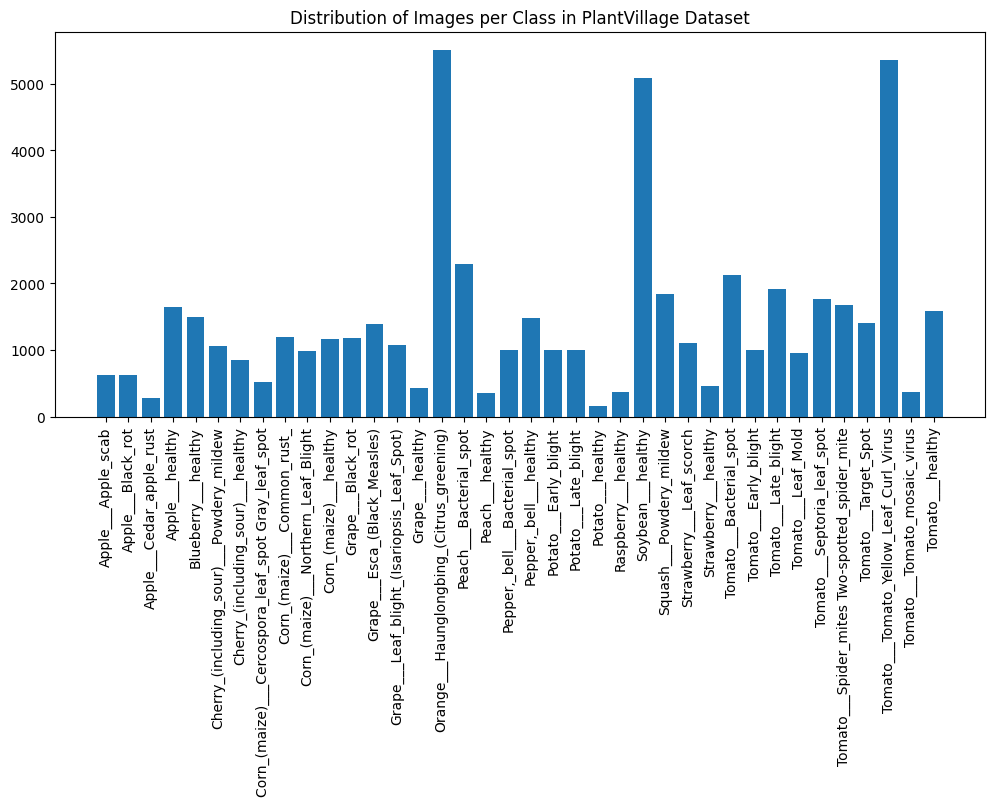

In [6]:
plt.figure(figsize=(12,5))
plt.bar(class_counts['Class'], class_counts['Image_counts'])
plt.xticks(rotation=90)

plt.title("Distribution of Images per Class in PlantVillage Dataset")
plt.show()

In [7]:
# splitting for train, val, test sets

X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels, test_size=0.3, random_state=123, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))


Train size: 38013
Val size: 8146
Test size: 8146


In [8]:
def process_image(file_path, label):
    # Loading the image from disk
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    return img, label

In [9]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.map(process_image).shuffle(1000).batch(batch_size)
val_ds = val_ds.map(process_image).batch(batch_size)
test_ds = test_ds.map(process_image).batch(batch_size)


I0000 00:00:1761020241.132478      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomBrightness(0.3),
    layers.RandomContrast(0.2),
])

In [11]:
from tensorflow.keras import models

baseline_cnn = models.Sequential([
        
    data_augmentation,  

    layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.4), 
    layers.Dense(len(classes), activation='softmax')
])

baseline_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,830 (382.15 KB)

 Trainable params: 97,446 (380.65 KB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
baseline_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)


In [14]:

history = baseline_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20


I0000 00:00:1761020259.387096     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 159s 126ms/step - accuracy: 0.3291 - loss: 2.6060 - val_accuracy: 0.3640 - val_loss: 2.3269 - learning_rate: 0.0010
Epoch 2/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 138s 115ms/step - accuracy: 0.5440 - loss: 1.6629 - val_accuracy: 0.5234 - val_loss: 1.6826 - learning_rate: 0.0010
Epoch 3/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 138s 115ms/step - accuracy: 0.6474 - loss: 1.2807 - val_accuracy: 0.5632 - val_loss: 1.8571 - learning_rate: 0.0010
Epoch 4/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 138s 115ms/step - accuracy: 0.7063 - loss: 1.0645 - val_accuracy: 0.5509 - val_loss: 1.8424 - learning_rate: 0.0010
Epoch 5/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 139s 116ms/step - accuracy: 0.7680 - loss: 0.8679 - val_accuracy: 0.7037 - val_loss: 1.1103 - learning_rate: 3.0000e-04
Epoch 6/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 138s 115ms/step - accuracy: 0.7863 - loss: 0.8018 - val_accuracy: 0.7598 - val_loss: 0.8652 - learning_rate: 3.0000e-04
Epoch 7/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 138s 116ms/st

In [15]:
# testing on the test set
test_loss, test_acc = baseline_cnn.evaluate(test_ds)
print("Baseline CNN Test Accuracy:", test_acc)


255/255 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.7953 - loss: 0.7687
Baseline CNN Test Accuracy: 0.7970783114433289


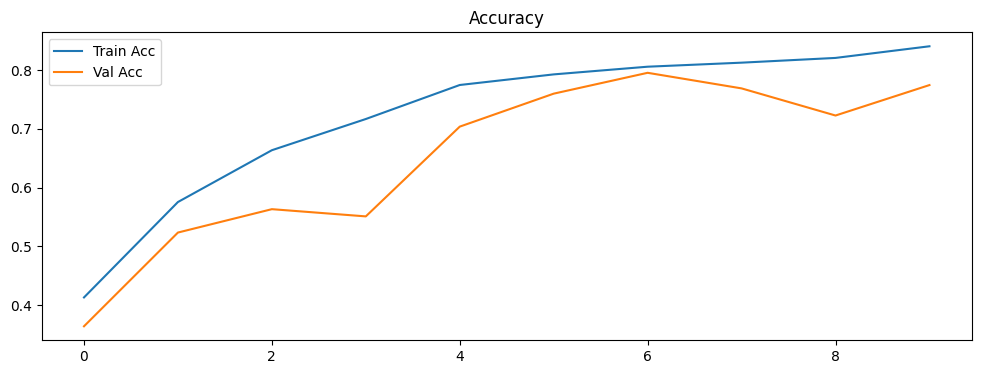

In [16]:
# accuracy plot

plt.figure(figsize=(12,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()


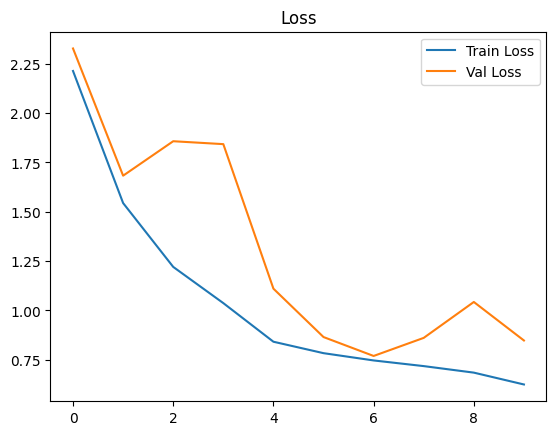

In [17]:
# loss plot


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_true = np.concatenate([y for x,y in test_ds], axis=0)
y_pred_probs = baseline_cnn.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

255/255 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step

Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.84      0.49      0.62        95
                                 Apple___Black_rot       0.60      0.60      0.60        93
                          Apple___Cedar_apple_rust       1.00      0.78      0.88        41
                                   Apple___healthy       0.60      0.87      0.71       247
                               Blueberry___healthy       0.88      0.96      0.92       226
          Cherry_(including_sour)___Powdery_mildew       0.93      0.91      0.92       158
                 Cherry_(including_sour)___healthy       0.89      0.66      0.76       128
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.65      0.79      0.71        77
                       Corn_(maize)___Common_rust_       0.99      0.94      0.96       179
            

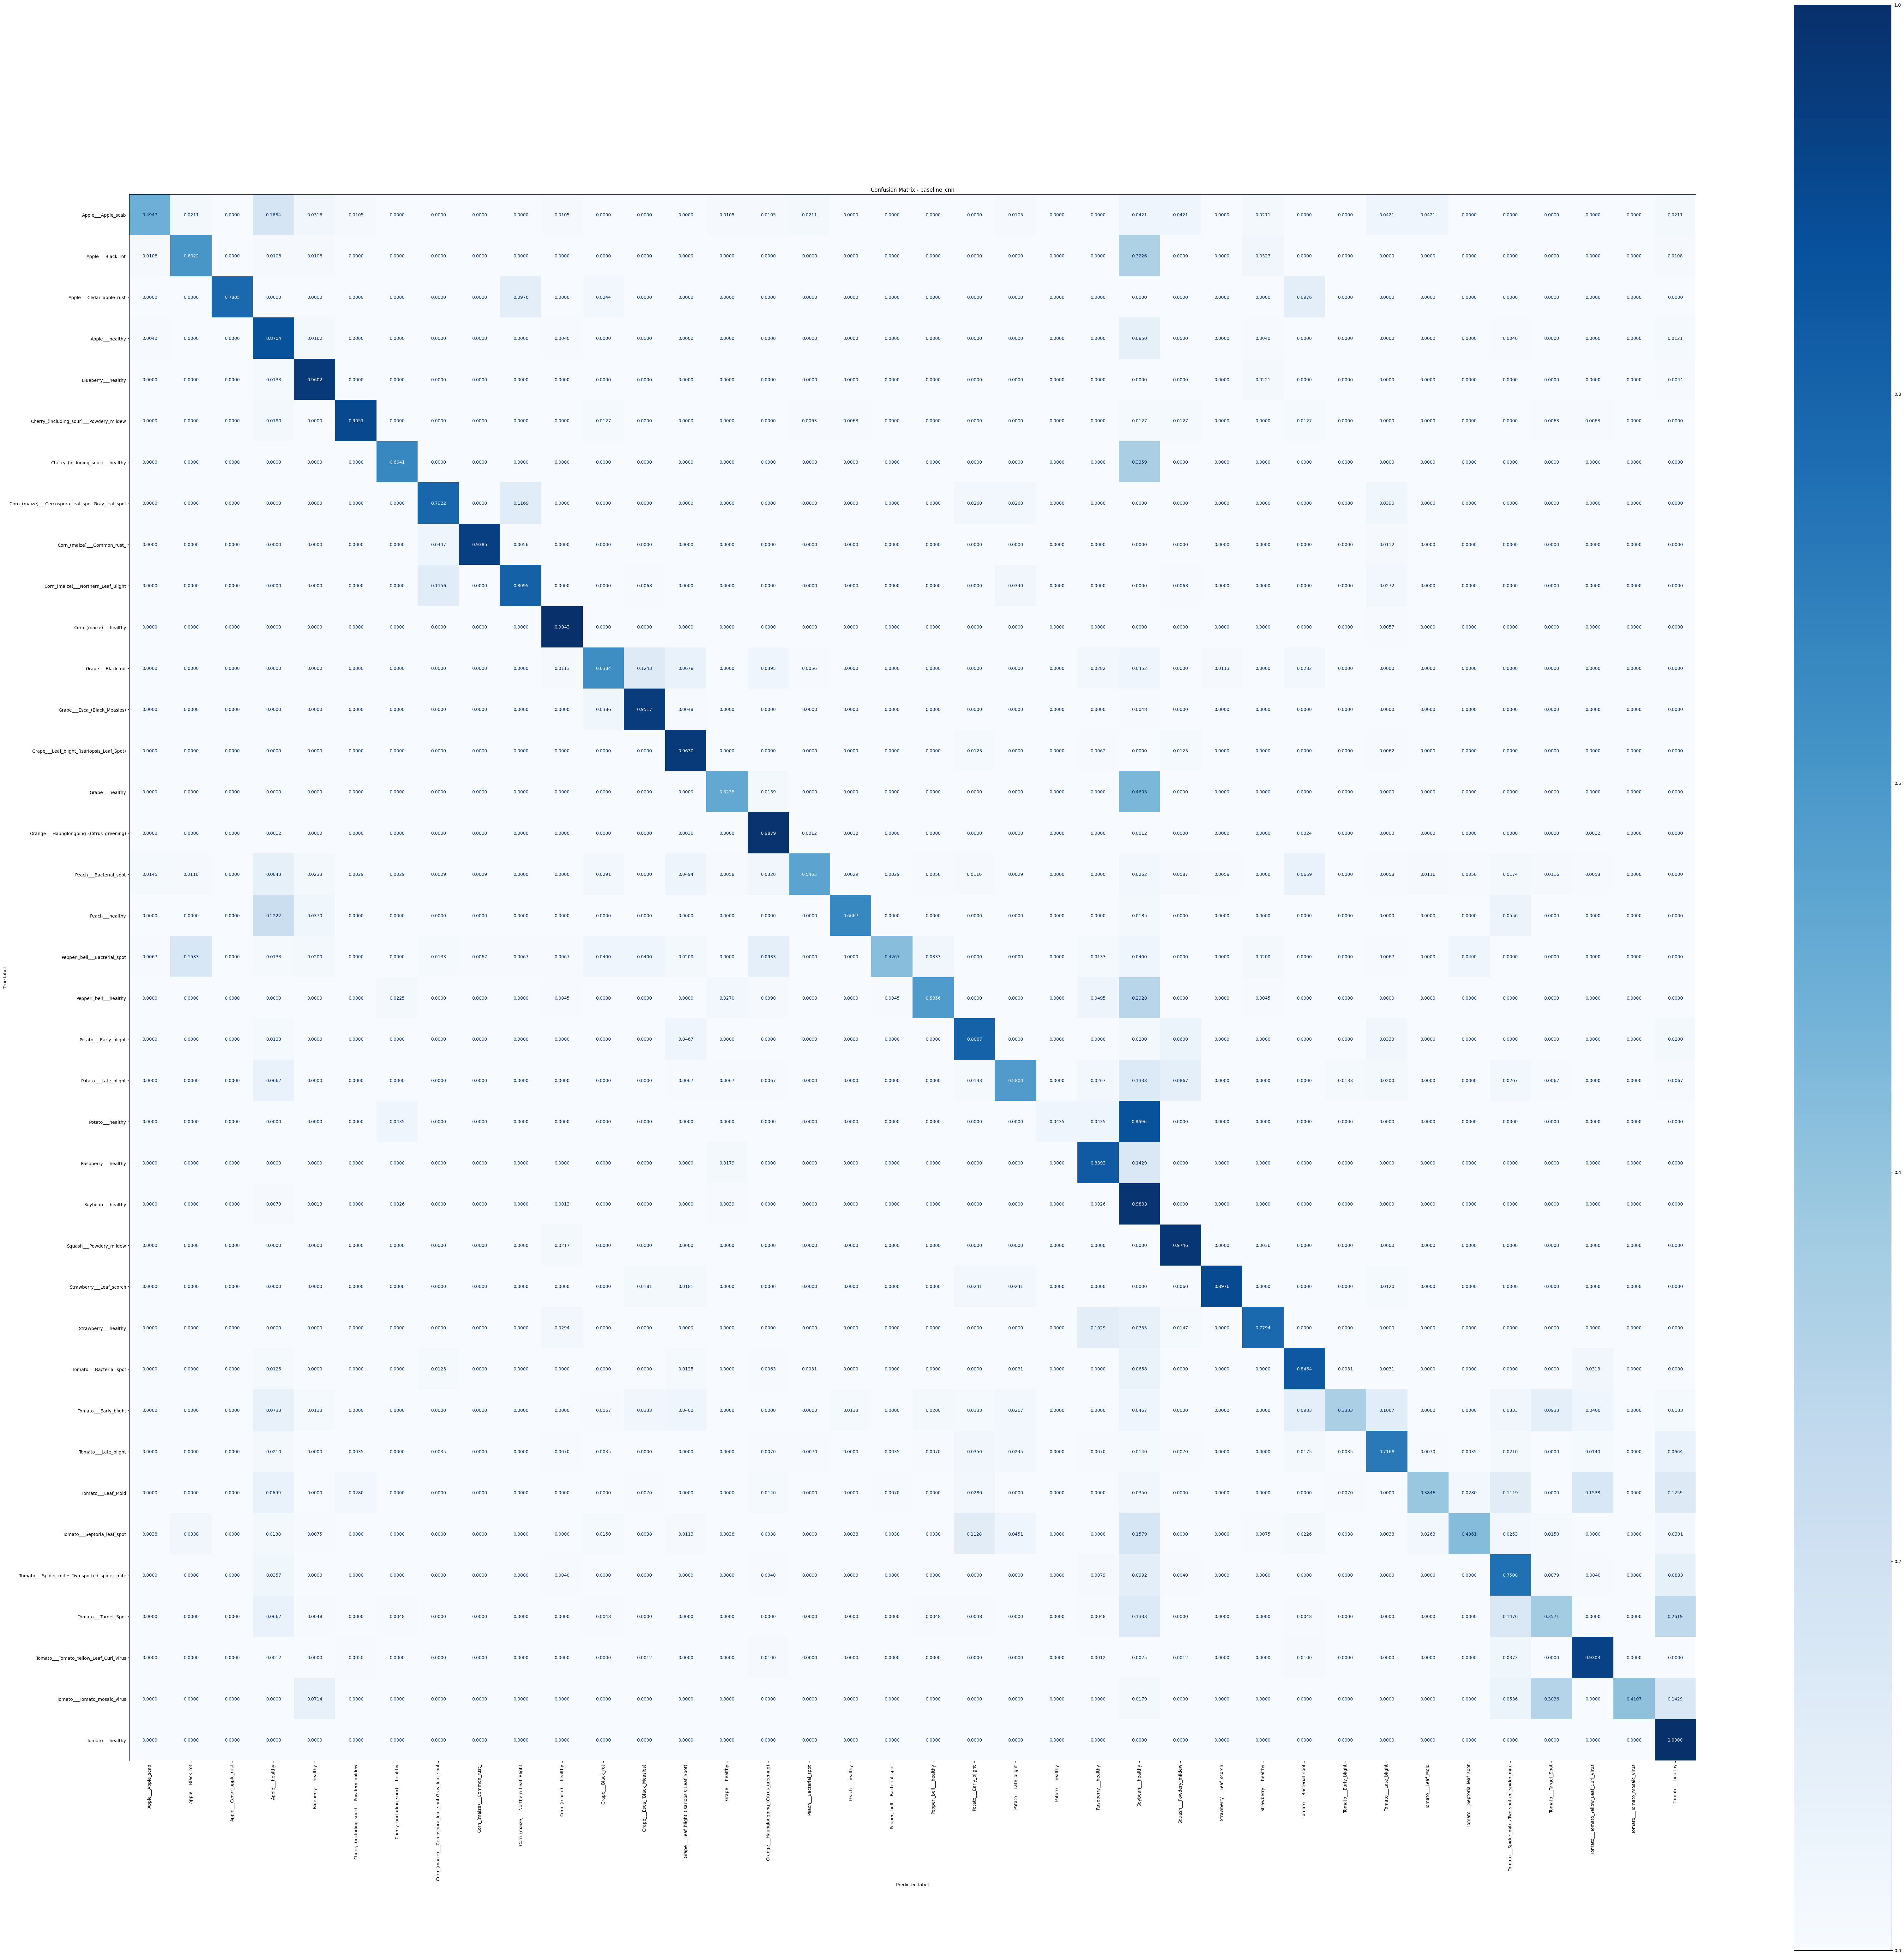

In [26]:
cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(80, 80))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=90, cmap='Blues', values_format='.4f', ax=plt.gca())
plt.title("Confusion Matrix - baseline_cnn")

plt.show()

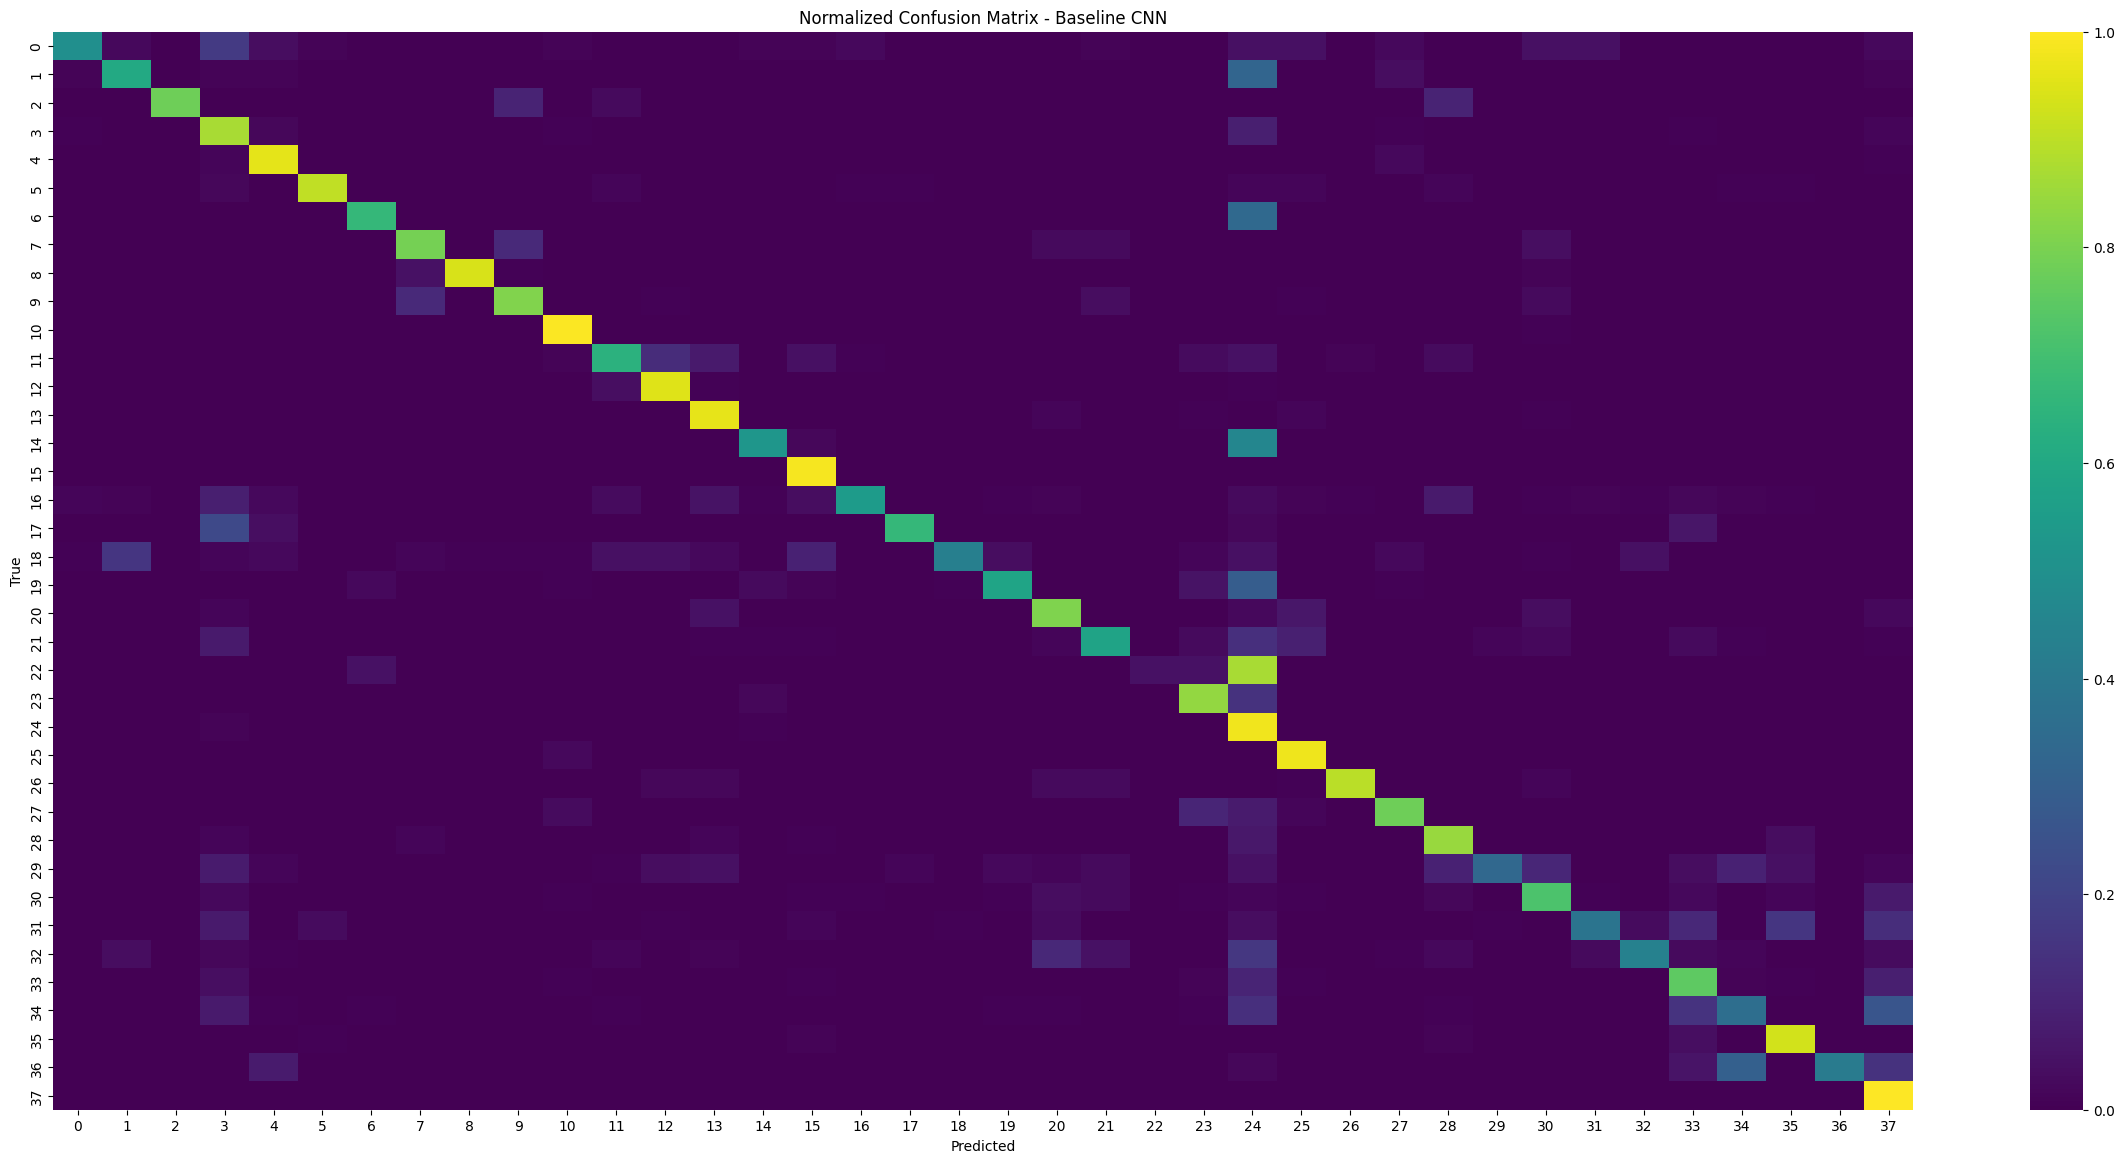

In [27]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(30, 14))
sns.heatmap(cm, annot=False, cmap='viridis')
plt.title("Normalized Confusion Matrix - Baseline CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [28]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_ds_resnet = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds_resnet = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds_resnet = test_ds.map(lambda x, y: (preprocess_input(x), y))

In [29]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input
import tensorflow as tf

inputs = Input(shape=(224, 224, 3),name="input_layer")
x = data_augmentation(inputs)

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)
base_model.trainable = False  

x = base_model.output  
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dense(256, activation='relu', name="head_dense")(x)
x = layers.Dropout(0.4, name="head_dropout")(x)
outputs = layers.Dense(len(classes), activation='softmax', name="predictions")(x)

resnet_model = models.Model(inputs, outputs)
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ sequential[1][0]  │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c

 Total params: 24,122,022 (92.02 MB)

 Trainable params: 534,310 (2.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [30]:

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:

history_resnet = resnet_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=15
)

Epoch 1/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 133s 102ms/step - accuracy: 0.4701 - loss: 1.9728 - val_accuracy: 0.8305 - val_loss: 0.5090
Epoch 2/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 118s 99ms/step - accuracy: 0.6518 - loss: 1.1668 - val_accuracy: 0.8479 - val_loss: 0.4299
Epoch 3/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 117s 98ms/step - accuracy: 0.6900 - loss: 1.0381 - val_accuracy: 0.8878 - val_loss: 0.3284
Epoch 4/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 118s 98ms/step - accuracy: 0.7029 - loss: 0.9927 - val_accuracy: 0.8683 - val_loss: 0.3959
Epoch 5/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 118s 98ms/step - accuracy: 0.7061 - loss: 0.9746 - val_accuracy: 0.8947 - val_loss: 0.3195
Epoch 6/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 118s 99ms/step - accuracy: 0.7130 - loss: 0.9512 - val_accuracy: 0.8903 - val_loss: 0.3400
Epoch 7/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 118s 99ms/step - accuracy: 0.7165 - loss: 0.9401 - val_accuracy: 0.8906 - val_loss: 0.3242
Epoch 8/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 118s 99ms/step - accuracy:

In [32]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = resnet_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 169s 127ms/step - accuracy: 0.6562 - loss: 1.2930 - val_accuracy: 0.9020 - val_loss: 0.3390 - learning_rate: 1.0000e-05
Epoch 2/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 149s 125ms/step - accuracy: 0.7568 - loss: 0.8228 - val_accuracy: 0.9100 - val_loss: 0.2949 - learning_rate: 1.0000e-05
Epoch 3/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 148s 124ms/step - accuracy: 0.7803 - loss: 0.7382 - val_accuracy: 0.9224 - val_loss: 0.2629 - learning_rate: 1.0000e-05
Epoch 4/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 148s 124ms/step - accuracy: 0.7901 - loss: 0.7039 - val_accuracy: 0.9316 - val_loss: 0.2284 - learning_rate: 1.0000e-05
Epoch 5/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 148s 124ms/step - accuracy: 0.7941 - loss: 0.6826 - val_accuracy: 0.9373 - val_loss: 0.2097 - learning_rate: 1.0000e-05
Epoch 6/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 148s 124ms/step - accuracy: 0.8040 - loss: 0.6524 - val_accuracy: 0.9396 - val_loss: 0.2064 - learning_rate: 1.0000e-05
Epoch 7/20
1188/1188 ━━━━━━━

In [33]:
test_loss, test_acc = resnet_model.evaluate(test_ds_resnet)
print("ResNet50 Test Accuracy:", test_acc)


255/255 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.9555 - loss: 0.1456
ResNet50 Test Accuracy: 0.9555609822273254


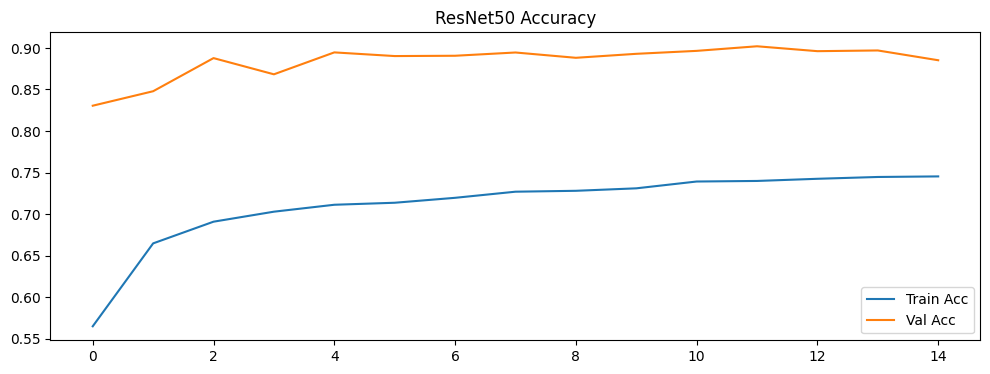

In [34]:
plt.figure(figsize=(12,4))

plt.plot(history_resnet.history['accuracy'], label='Train Acc')
plt.plot(history_resnet.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("ResNet50 Accuracy")
plt.show()

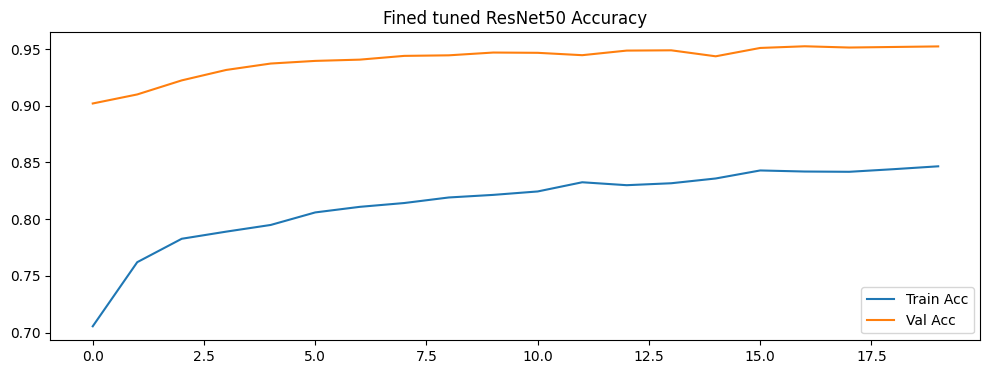

In [39]:
plt.figure(figsize=(12,4))

plt.plot(history_finetune.history['accuracy'], label='Train Acc')
plt.plot(history_finetune.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Fined tuned ResNet50 Accuracy")
plt.show()

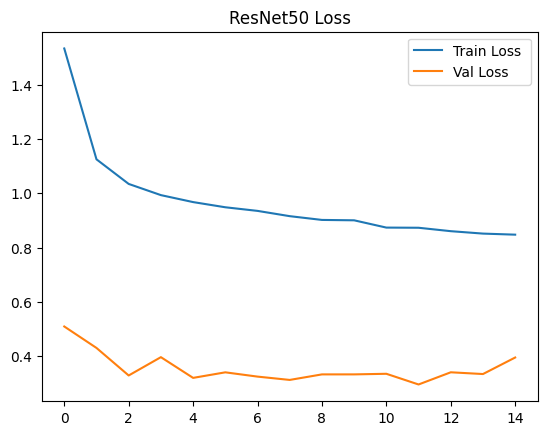

In [35]:
plt.plot(history_resnet.history['loss'], label='Train Loss ')
plt.plot(history_resnet.history['val_loss'], label='Val Loss ')
plt.legend()
plt.title("ResNet50 Loss")
plt.show()

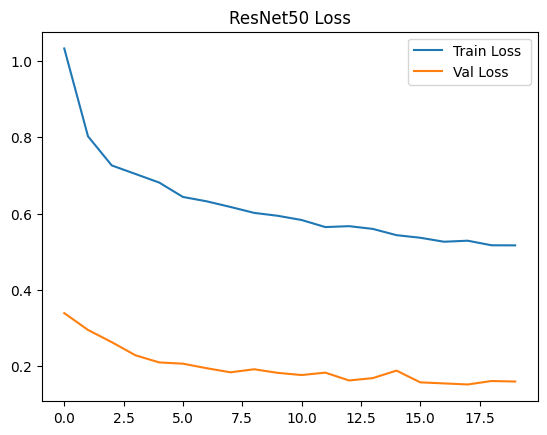

In [40]:
plt.plot(history_finetune.history['loss'], label='Train Loss ')
plt.plot(history_finetune.history['val_loss'], label='Val Loss ')
plt.legend()
plt.title("ResNet50 Loss")
plt.show()

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_true_resnet = np.concatenate([y for x,y in test_ds_resnet], axis=0)
y_pred_resnet_probs = resnet_model.predict(test_ds_resnet)
y_pred_resnet = np.argmax(y_pred_resnet_probs, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true_resnet, y_pred_resnet, target_names=classes))

255/255 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step

Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.92      0.95        95
                                 Apple___Black_rot       0.98      1.00      0.99        93
                          Apple___Cedar_apple_rust       0.97      0.93      0.95        41
                                   Apple___healthy       0.98      0.99      0.98       247
                               Blueberry___healthy       1.00      1.00      1.00       226
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       158
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       128
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.85      0.90      0.87        77
                       Corn_(maize)___Common_rust_       1.00      0.99      1.00       179
           

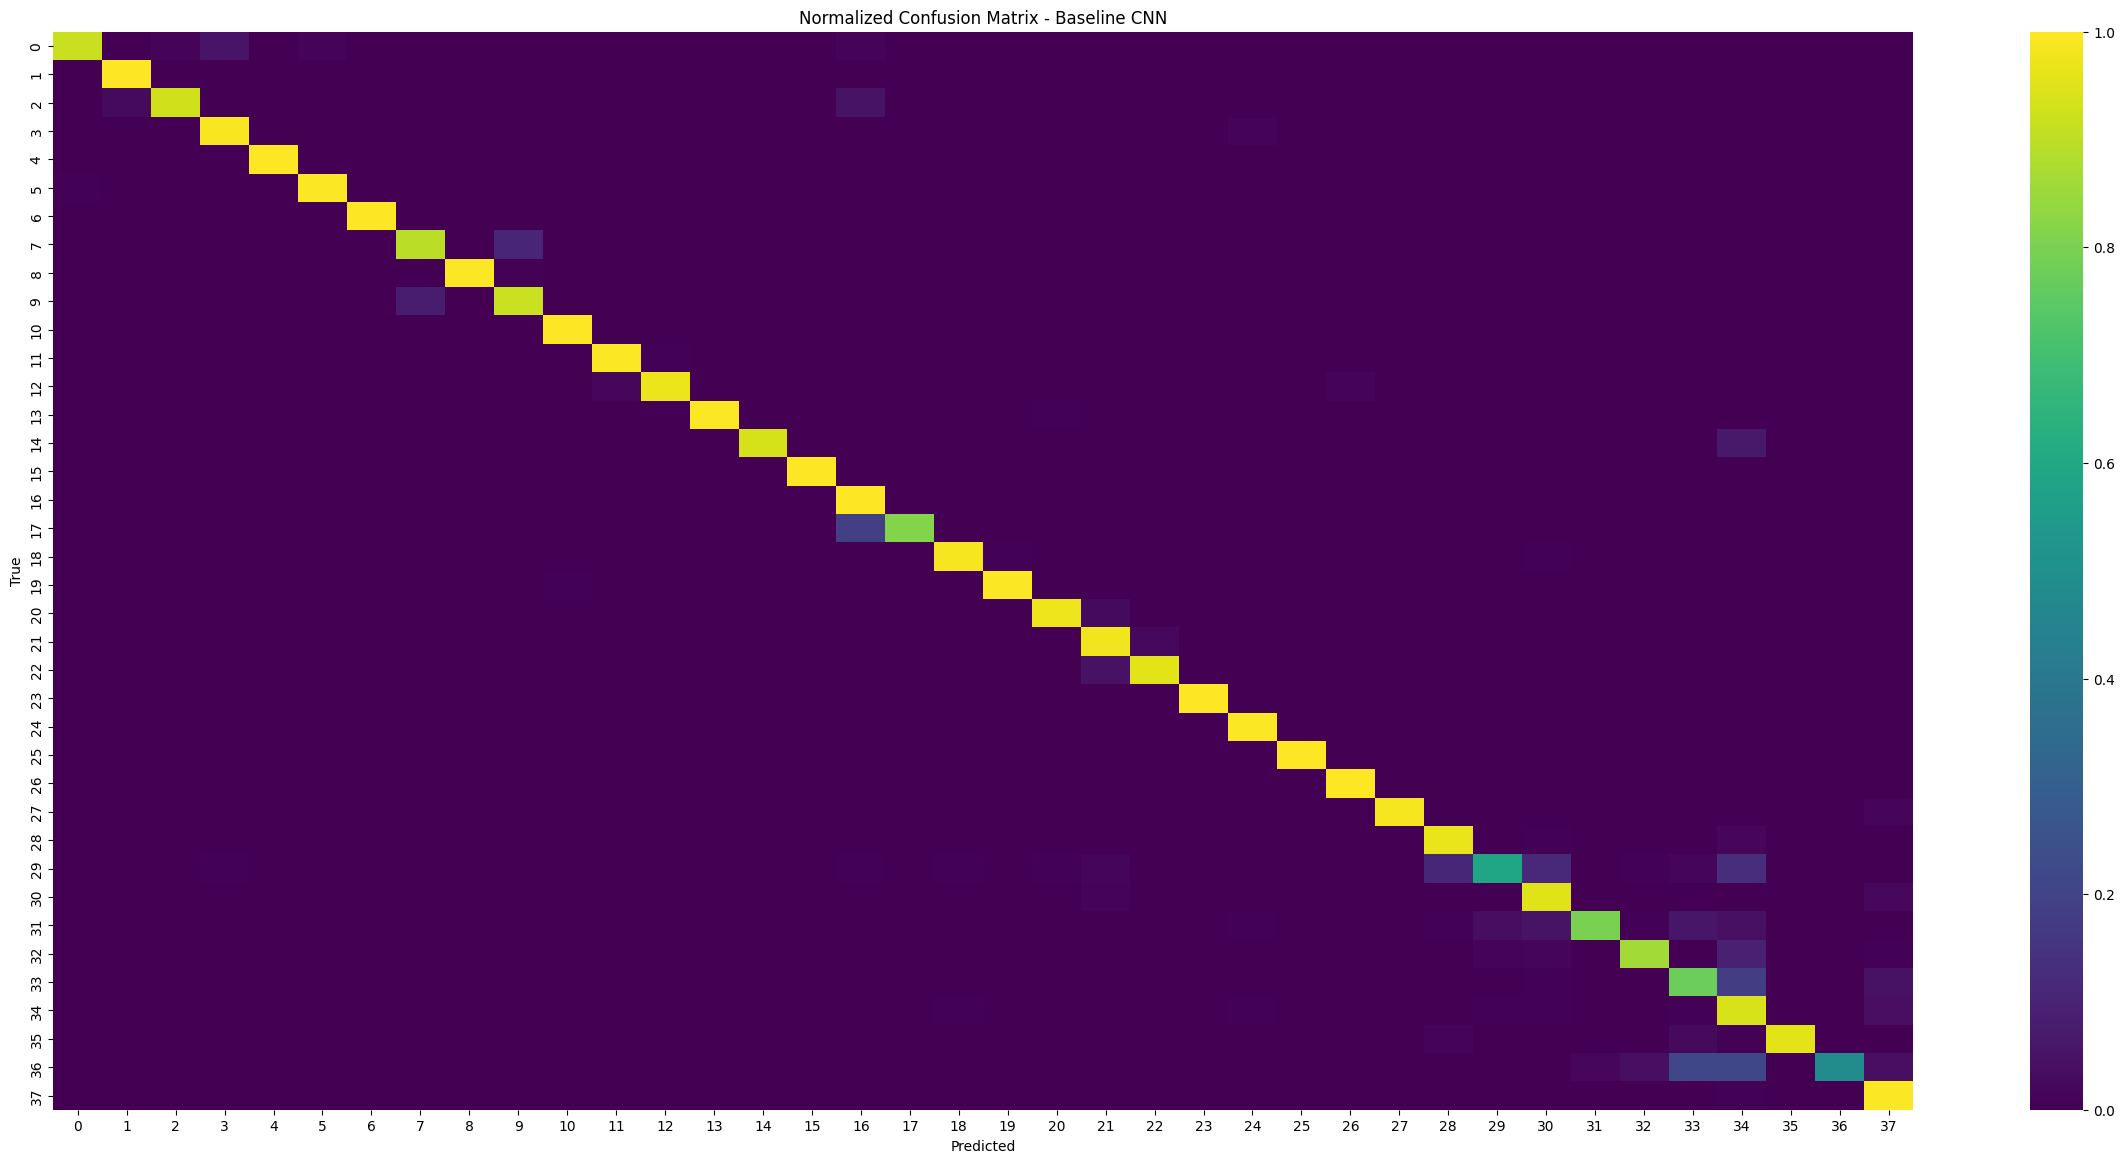

In [37]:
import seaborn as sns

cm = confusion_matrix(y_true_resnet, y_pred_resnet, normalize='true') 
plt.figure(figsize=(30, 14))
sns.heatmap(cm, annot=False, cmap='viridis')
plt.title("Normalized Confusion Matrix - Baseline CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

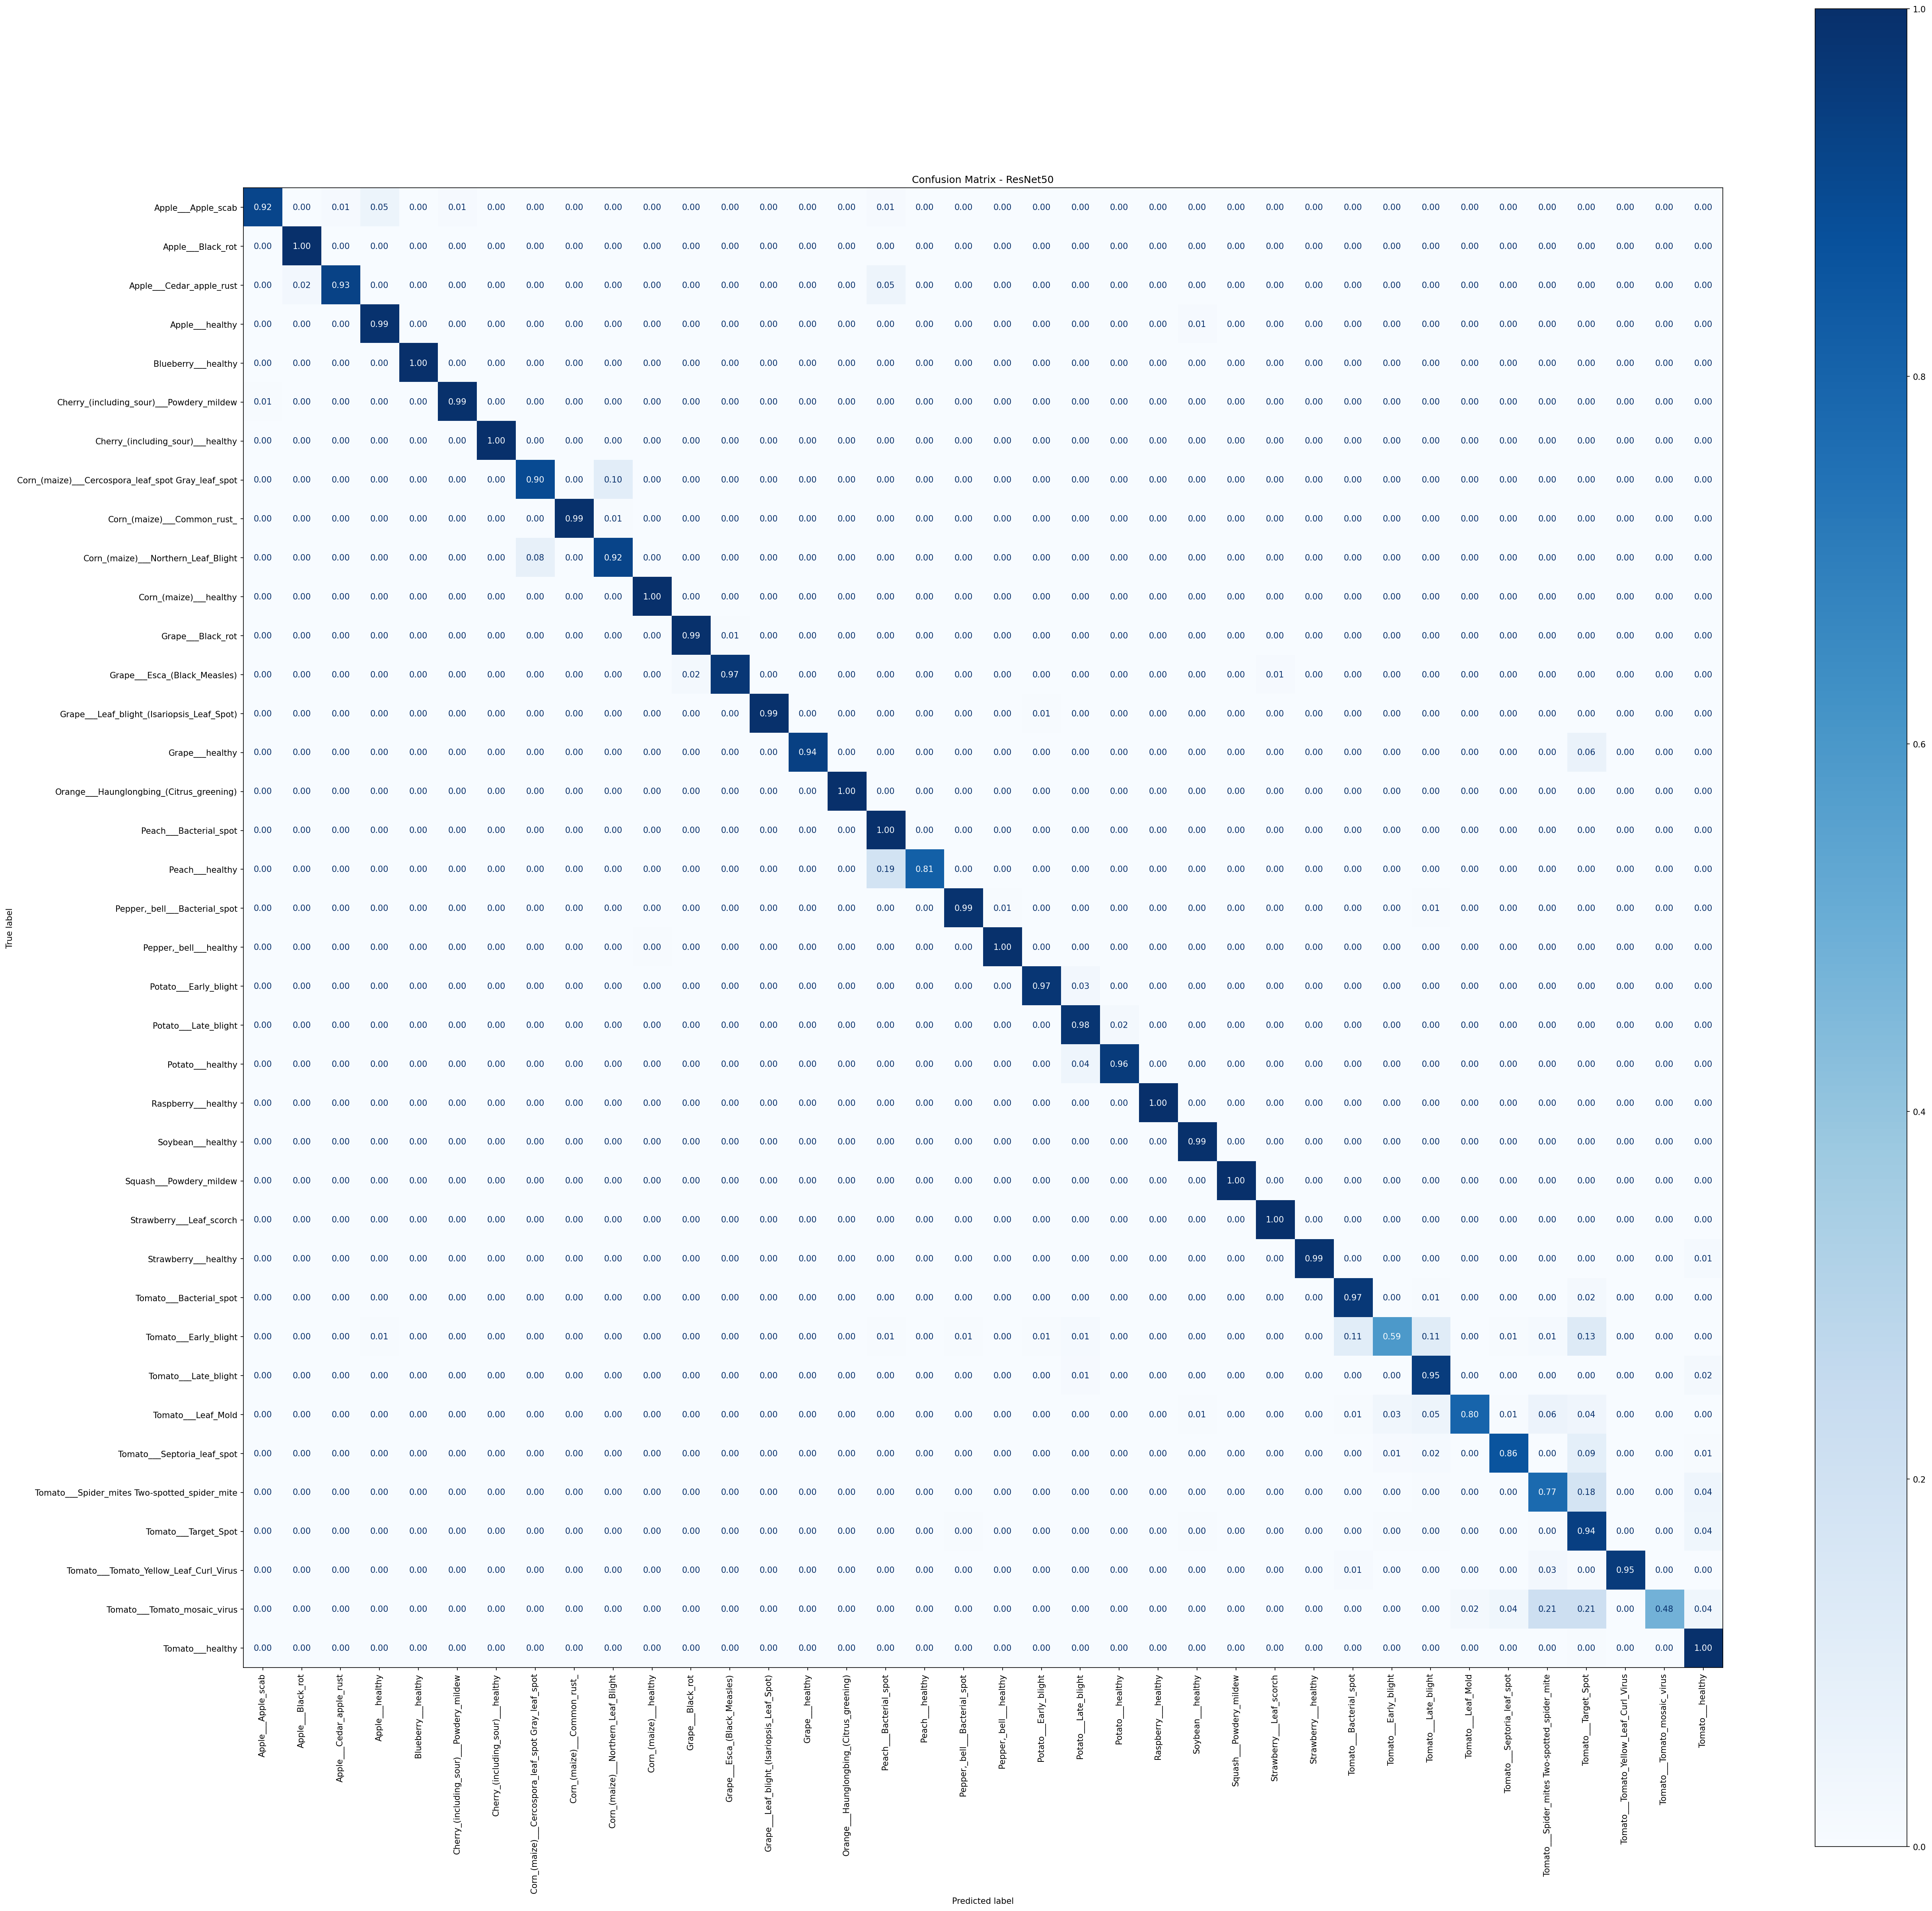

In [41]:
cm = confusion_matrix(y_true_resnet, y_pred_resnet, normalize='true')
plt.figure(figsize=(40, 40), dpi=150)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=90, cmap='Blues', values_format='.2f', ax=plt.gca())
plt.title("Confusion Matrix - ResNet50")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


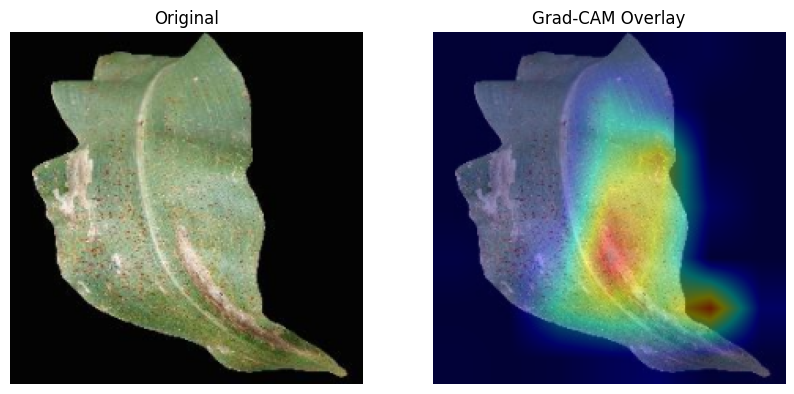

In [42]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv5_block3_out'):
    
    last_conv_layer = model.get_layer(last_conv_layer_name)

    grad_model = tf.keras.models.Model(
        inputs=[model.inputs], 
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()


img_path = "/kaggle/input/plantvillage-dataset/color/Corn_(maize)___Common_rust_/RS_Rust 1563.JPG"
img = image.load_img(img_path, target_size=(224, 224))
img_array = np.expand_dims(image.img_to_array(img), axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Use ResNet preprocessing


heatmap = make_gradcam_heatmap(img_array, resnet_model, last_conv_layer_name='conv5_block3_out')

# overlay and plot
img_orig = cv2.imread(img_path)
img_orig = cv2.resize(img_orig, (224, 224))

heatmap_resized = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Grad-CAM Overlay")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
resnet_model.save_weights("resnet_model.keras.weights.h5")
